In [ ]:
pip install memory_profiler

# **Numba Implementation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import pandas as pd
plt.rcParams["figure.figsize"] = (14, 11)  #set default figure size
plt.rcParams["font.size"] = 20 #set default font size
from numba import cuda, jit, njit
import time as time_counter
import memory_profiler
from memory_profiler import profile

In [ ]:
vp = np.load('/content/Marmousi_cropped.npy')

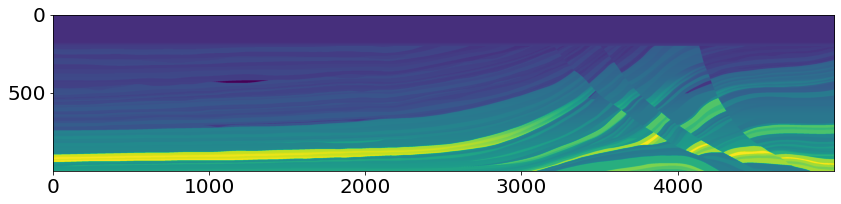

In [ ]:
plt.imshow(vp)

In [ ]:
nx = vp.shape[1] # number of grid points in the horizontal direction
nz = vp.shape[0] # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 50 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)
vp = vp[:nz, :nx]
# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model

#vp = np.ones((nx,nz))*3000.0

time = np.arange(0,nt*dt,dt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
wav  = (1.0-2.0*np.power(np.pi*f0*(time-t0),2))*np.exp(-np.power(np.pi*f0*(time-t0),2)) # computing the wavelet

In [ ]:
assert dt < dd/(np.sqrt(2.0)*np.max(vp)),'Courant not satisfied!' # making sure Courant number is fine

In [ ]:
@jit
def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = np.ones((nx,nz))
    abs_coefs = np.zeros(nabs)
    abs_coefs = np.exp(-(a**2 * (nabs-np.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    return absorb

In [ ]:
@jit
def comp_deriv(p,dd):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    return pdx2, pdz2

In [ ]:
@jit
def fd_ac(vp,dd,dt,srcx,srcz,wav,nabs=40,a=0.0053,FreeSurf=False):
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    nx,nz = vp.shape # infer shapes
    nt = wav.shape[0]

    field2d = np.zeros((nx,nz,nt),dtype=np.float64) # define variables  - field2d is output wavefield
    p = np.zeros((nx,nz),dtype=np.float64) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx,nz),dtype=np.float64)
    pfut = np.zeros((nx,nz),dtype=np.float64)
    
    vp2 = vp**2 # square of velocity for easier computation
    absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = comp_deriv(p,dd) # compute pressure derivatives
        pfut = 2 * p + vp2 * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
        
        p *= absorb # apply absorbing mask
        pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut
    return field2d

In [ ]:
%%timeit
wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf) # example computation

1 loop, best of 5: 10.8 s per loop


In [ ]:
time_numba = {'2500х500': 3.46,
              '3000х600': 4.59,
              '3500х700': 5.96,
              '4000х800': 7.51,
              '4500х900': 9.23,
              '5000х1000': 9.27}

In [ ]:
%%writefile FP_cupy.py

import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
# from numba import jit, njit
import time as time_counter
import memory_profiler
from memory_profiler import profile

vp = np.load('Marmousi_cropped.npy')

nx = 800 # number of grid points in the horizontal direction
nz = 400 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 1500 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 900 # source horizontal location in meters
srcz = 800 # source vertical location in meters

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model

#vp = np.ones((nx,nz))*3000.0

time = cp.arange(0,nt*dt,dt) # time vector
# time = cp.asnumpy(time)
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
pow_1 = cp.power(cp.pi*f0*(time-t0),2)
# pow_1 = cp.asnumpy(pow_1)
pow_2 = cp.power(cp.pi*f0*(time-t0),2)
# pow_2 = cp.asnumpy(pow_2)

wav  = (1.0-2.0*pow_1)*cp.exp(-pow_2) # computing the wavelet

assert dt < dd/(np.sqrt(2.0)*np.max(vp)),'Courant not satisfied!' # making sure Courant number is fine

@profile
def gen_absorb(nx,nz,nabs,a,FreeSurf=False):
    absorb = cp.ones((nx,nz))
    abs_coefs = cp.zeros(nabs)
    abs_coefs = cp.exp(-(a**2 * (nabs-cp.arange(nabs))**2))
    absorb[:nabs,:] = absorb[:nabs,:]*cp.expand_dims(abs_coefs,1)
    absorb[-nabs:,:] = absorb[-nabs:,:]*cp.expand_dims(abs_coefs[::-1],1)
    absorb[:,-nabs:] = absorb[:,-nabs:]*abs_coefs[::-1]
    if(FreeSurf==False):
        absorb[:,:nabs] = absorb[:,:nabs]*abs_coefs
    absorb = cp.asnumpy(absorb)
    return absorb

@profile
def comp_deriv(p,dd):
    pdx2 = cp.zeros(p.shape)
    pdx2 = cp.asnumpy(pdx2)
    pdz2 = cp.zeros(p.shape)
    pdz2 = cp.asnumpy(pdz2)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    return pdx2, pdz2

@profile
def fd_ac(vp,dd,dt,srcx,srcz,wav,nabs=40,a=0.0053,FreeSurf=False):
    srci = int(srcx/dd) # find where source is located on the grid
    srcj = int(srcz/dd)
    nx,nz = vp.shape # infer shapes
    nt = wav.shape[0]

    field2d = cp.zeros((nx,nz,nt))#,dtype=cp.float32) # define variables  - field2d is output wavefield
    field2d = cp.asnumpy(field2d)
    field2d = field2d.astype(cp.float32)
    p = np.zeros((nx,nz))#,dtype=np.float32) # these are pressures at current, prev and next steps
    p = cp.asnumpy(p)
    p = p.astype(cp.float32)
    ppast = np.zeros((nx,nz))#,dtype=np.float32)
    ppast = cp.asnumpy(ppast)
    ppast = ppast.astype(cp.float32)
    pfut = np.zeros((nx,nz))#,dtype=np.float32)
    pfut = cp.asnumpy(pfut)
    pfut = pfut.astype(cp.float32)
    
    vp2 = vp**2 # square of velocity for easier computation
    absorb = gen_absorb(nx,nz,nabs,a,FreeSurf=FreeSurf) # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = comp_deriv(p,dd) # compute pressure derivatives
        pfut = 2 * p + vp2 * dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 
        pfut[srci,srcj] = pfut[srci,srcj] + wav[i] / (dd * dd) * dt ** 2 # inject source term at selected point
        
        p *= absorb # apply absorbing mask
        pfut *= absorb # apply absorbing mask

        field2d[:,:,i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut
    return field2d

wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf) # example computation

Writing FP_cupy.py


In [ ]:
!mprof run FP_cupy.py

Выходные данные были обрезаны до нескольких последних строк (5000).
    50   3766.8 MiB   3766.8 MiB           1   @profile
    51                                         def comp_deriv(p,dd):
    52   3766.8 MiB      0.0 MiB           1       pdx2 = np.zeros(p.shape)
    53   3766.8 MiB      0.0 MiB           1       pdz2 = np.zeros(p.shape)
    54                                         
    55   3766.8 MiB      0.0 MiB           1       pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(dd**2)
    56   3766.8 MiB      0.0 MiB           1       pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(dd**2)
    57   3766.8 MiB      0.0 MiB           1       return pdx2, pdz2


Filename: FP.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    50   3766.8 MiB   3766.8 MiB           1   @profile
    51                                         def comp_deriv(p,dd):
    52   3766.8 MiB      0.0 MiB           1       pdx2 = np.zeros(p.shape)
    53   3766.8 MiB   

In [ ]:
!mprof plot

Using last profile data.
<Figure size 1260x540 with 1 Axes>


In [ ]:
path = 'mprofile_20211220010950.dat'
df = pd.read_csv(path, sep=' ', skiprows=0).iloc[0:,1]
df = df.to_numpy()

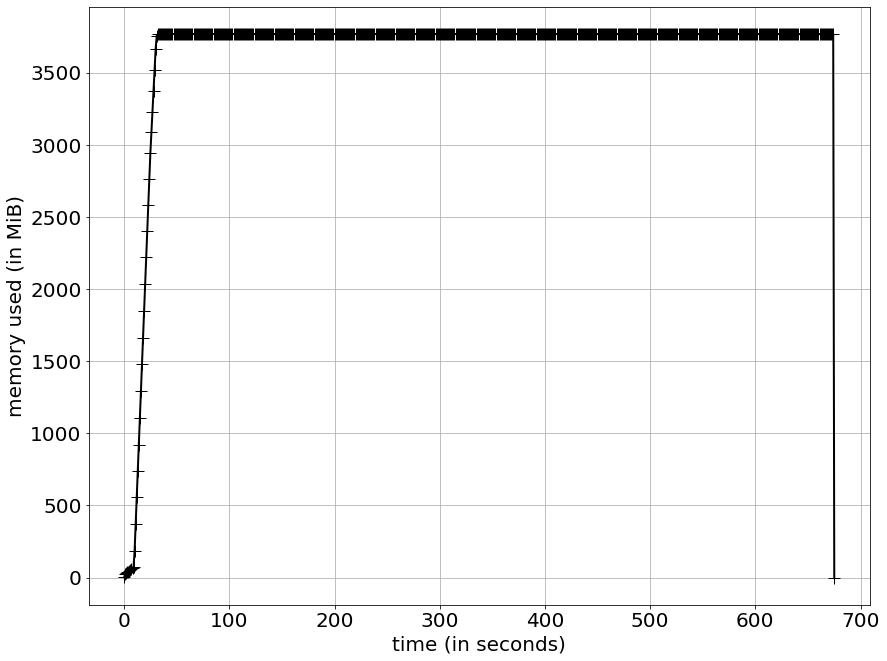

In [ ]:
plt.plot(df, color='black', linewidth=2, markersize=12, marker='+')
plt.ylabel('memory used (in MiB)')
plt.xlabel('time (in seconds)')
plt.grid()